All equations adapted from MATLAB examples found in:

Voelz, David. "Computational fourier optics: a MATLAB tutorial." Society of     Photo-Optical Instrumentation Engineers, 2011.

In [1]:
from numba import jit
import scipy
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt

# force it to use these data types for complex and float
complex_type = np.complex128
float_type = np.float64

In [2]:
lambda_0 = 0.5e-6
f = 10e-2
(4*lambda_0*f**3/np.pi)**(1/4)

0.005023079256810667

In [46]:
@jit(nopython=True)
def numba_meshgrid(a, b, indexing_xy=True):
    outA = np.zeros((len(a),len(b)))
    outB = np.zeros((len(a),len(b)))
    if indexing_xy:
        for x in range(0,len(a)):
            for y in range(0,len(b)):
                outA[y,x] = np.float(a[x])
                outB[y,x] = np.float(b[y])
    else:
        for x in range(0,len(a)):
            for y in range(0,len(b)):
                outA[x,y] = np.float(a[x])
                outB[x,y] = np.float(b[y])
    return outA,outB

@jit(nopython=True)
def distMat(px, py, X, Y, z):
    return(np.sqrt((X - px)**2 + (Y - py)**2 + z**2))

@jit(nopython=True)
def distMat2(px, py, X, Y, z):
    return((X - px)**2 + (Y - py)**2 + z**2)

def propFull(u1, L, lambda_0, z):
    # full propgation of the Rayleigh–Sommerfeld solution (Eq 4.12)
    u1 = u1.astype(complex_type)
    (M,N)=np.shape(u1)
    L = float_type(L)
    lambda_0 = float_type(lambda_0)
    z = float_type(z)
    M = float_type(M)
    N = float_type(N)
    dx = float_type(L/M)
    k = float_type(2*np.pi/lambda_0)
    x = np.linspace(-L/2,L/2,int(M))
    (X,Y) = np.meshgrid(x,x)
    X = X.astype(float_type)
    Y = Y.astype(float_type)
    uo = np.zeros(np.shape(u1), dtype=complex_type)
    for oi_x in range(0,int(M)):
        for oi_y in range(0,int(N)):
            sums = 0
            r01_2 = distMat2(X[oi_x,oi_y], Y[oi_x,oi_y], X, Y, z)
            uo[oi_x, oi_y] = (z/(complex_type(1j)*lambda_0))*np.sum(u1*np.exp(complex_type(1j)*k*np.sqrt(r01_2))/r01_2)
    return uo

def propIR(u1, L, lambda_0, z):
    # Fresnel Impulse Response (IR) Propagator
    # propagation transfer function assumes same x and y side lengths and uniform sampling
    # u1 - source plane field
    # L - source and observation plane side lengths
    # lambda_0 wavelength
    # z - propagation distance
    # u2 - observation plane field    
    u1 = u1.astype(complex_type)
    (M,N)=np.shape(u1)
    L = float_type(L)
    lambda_0 = float_type(lambda_0)
    z = float_type(z)
    M = float_type(M)
    N = float_type(N)
    dx = float_type(L/M)
    k = float_type(2.0*np.pi/lambda_0)
    x = np.linspace(-L/2,L/2,int(M))
    (X,Y) = np.meshgrid(x,x)
    X = X.astype(float_type)
    Y = Y.astype(float_type)
    h = 1/(complex_type(1j)*lambda_0*z)*np.exp(complex_type(1j)*k/(2*z)*(X**2+Y**2))
    H = np.fft.fft2(np.fft.fftshift(h))*dx**2
    U1 = np.fft.fft2(np.fft.fftshift(u1))
    U2 = H*U1
    u2 = np.fft.ifftshift(np.fft.fft2(U2))
    return u2
    
def propTF(u1, L, lambda_0, z):
    # Fresnel Transfer Function
    # propagation transfer function assumes same x and y side lengths and uniform sampling
    # u1 - source plane field
    # L - source and observation plane side lengths
    # lambda_0 wavelength
    # z - propagation distance
    # u2 - observation plane field
    u1 = u1.astype(complex_type)
    (M,N)=np.shape(u1)
    L = float_type(L)
    lambda_0 = float_type(lambda_0)
    z = float_type(z)
    M = float_type(M)
    N = float_type(N)
    dx = float_type(L/M)
    k = float_type(2.0*np.pi/lambda_0)
    fx = np.linspace(-1/(2*dx),1/(2*dx),int(M))
    (FX,FY) = np.meshgrid(fx,fx)
    FX.astype(float_type)
    FY.astype(float_type)
    H = np.exp(-complex_type(1j)*np.pi*lambda_0*z*(FX**2.0+FY**2.0))
    H = np.fft.fftshift(H)
    U1 = np.fft.fft2(np.fft.fftshift(u1))
    U2 = H*U1
    u2 = np.fft.ifftshift(np.fft.fft2(U2))
    return u2

def propFF(u1,L1,lambda_0,z):
    # Fraunhofer Propagation
    # propagation - Fraunhofer pattern assumes unifom sampling
    # u1 - source plane field
    # L1 - source plane side length
    # lambda_0 wavelngth
    # z - propagation distance
    # L2 - oversvation plane side length
    # u2 oversvation plane field
    u1 = u1.astype(complex_type)
    (M,N)=np.shape(u1)
    L1 = float_type(L1)
    lambda_0 = float_type(lambda_0)
    z = float_type(z)
    M = float_type(M)
    N = float_type(N)
    dx1 = float_type(L1/M)
    k = float_type(2*np.pi/lambda_0)
    L2 = float_type(lambda_0*z/dx1)
    dx2 = float_type(lambda_0*z/L1)
    x2 = np.linspace(-L2/float_type(2),L2/float_type(2)-dx2,int(M))
    (X2,Y2) = np.meshgrid(x2,x2)
    X2 = X2.astype(float_type)
    Y2 = Y2.astype(float_type)
    c = float_type(1)/(complex_type(1j)*lambda_0*z)\
        *np.exp(complex_type(1j)*k/(float_type(2)*z)*(X2**2+Y2**2))
    u2=c*np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(u1)))*(dx1**2)
    return u2

def tilt(uin,L,lambda_0,alpha,theta):
    # tilt phasefront
    # uniform sampling assumed
    # uin - input field
    # L - side length
    # lambda_0 - wavelength
    # alpha - tilt angle
    # theta - rotation angle
    u1 = u1.astype(complex_type)
    (M,N)=np.shape(uin)
    L = float_type(L)
    lambda_0 = float_type(lambda_0)
    alpha = float_type(alpha)
    theta = float_type(theta)
    M = float_type(M)
    N = float_type(N)
    dx = float_type(L/M)
    k = float_type(2.0*np.pi/lambda_0)
    x = np.linspace(-L/2,L/2,int(M))
    (X,Y) = np.meshgrid(x,x)
    X = X.astype(float_type)
    Y = Y.astype(float_type)
    uout = uin*np.exp(complex_type(1j)*k*(X*np.cos(theta) + Y*np.sin(theta))*np.tan(alpha))
    return(uout)

def rect(x):
    y = np.zeros(np.shape(x)).astype(float)
    y[np.abs(x) < 0.5] = 1.0
    y[np.abs(x) == 0.5] = 0.5
    return(y)

def focus(uin,L,lambda_0,zf):
    # converging or diverging phase-front
    # uniform sampling assumed
    # uin - input field
    # L - side length
    # lambda -wavelength
    # zf = focal distance (+ converge, - diverge)
    # uout - output field
    uin = uin.astype(complex_type)
    (M,N)=np.shape(uin)
    L = float_type(L)
    lambda_0 = float_type(lambda_0)
    zf = float_type(zf)
    M = float_type(M)
    N = float_type(N)
    dx = float_type(L/M)
    k = float_type(2*np.pi/lambda_0)
    x = np.linspace(-L/2,L/2,int(M))
    (X,Y) = np.meshgrid(x,x)
    X = X.astype(float_type)
    Y = Y.astype(float_type)
    return uin*np.exp(-complex_type(1j)*k/(2*zf)*(X**2+Y**2))

Text(0.5, 1.0, 'Fraunhofer Propagation')

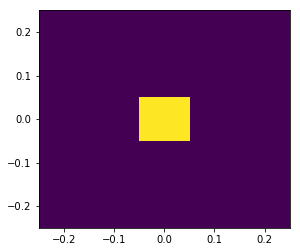

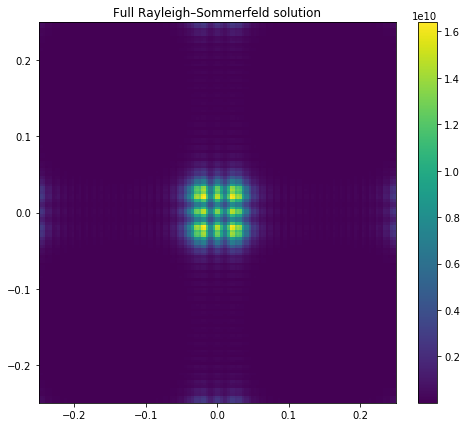

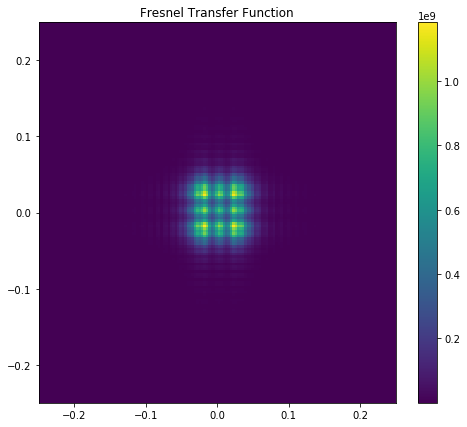

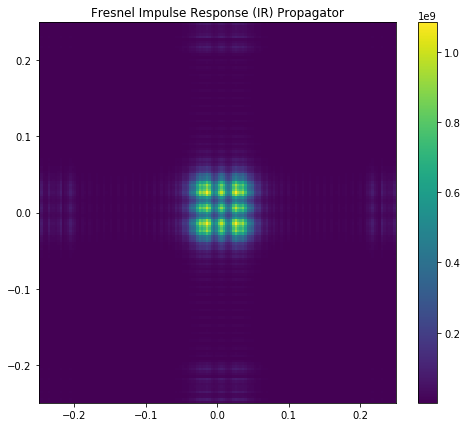

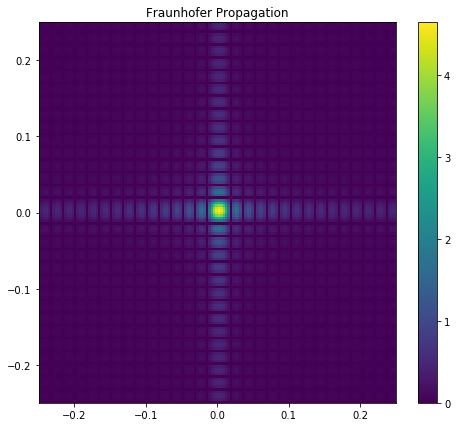

In [49]:
L1 = float(0.5)
M=float(150)
lambda_0=0.5e-6
k=2*np.pi/lambda_0
w=0.051
z=2000

dx1=L1/M
x1=np.linspace(-L1/2,L1/2,np.int(L1/dx1))
y1=x1

(X1,Y1)=np.meshgrid(x1,y1)

u1 = rect(X1/(2*w))*rect(Y1/(2*w))

plt.figure(figsize=(4.5,4))
plt.pcolormesh(x1,y1,np.abs(u1**2))

u2 = propFull(u1,L1,lambda_0,z)
u2_tf = propTF(u1,L1,lambda_0,z)
u2_ir = propIR(u1,L1,lambda_0,z)
u2_ff = propFF(u1,L1,lambda_0,z)

I2 = np.real(u2*np.conj(u2))
I2_tf = np.real(u2_tf*np.conj(u2_tf))
I2_ir = np.real(u2_ir*np.conj(u2_ir))
I2_ff = np.real(u2_ff*np.conj(u2_ff))

plt.figure(figsize=(8,7))
plt.pcolormesh(x1,y1,I2)
plt.colorbar()
plt.title('Full Rayleigh–Sommerfeld solution')

plt.figure(figsize=(8,7))
plt.pcolormesh(x1,y1,I2_tf)
plt.colorbar()
plt.title('Fresnel Transfer Function')

plt.figure(figsize=(8,7))
plt.pcolormesh(x1,y1,I2_ir)
plt.colorbar()
plt.title('Fresnel Impulse Response (IR) Propagator')

plt.figure(figsize=(8,7))
plt.pcolormesh(x1,y1,I2_ff**(1.0/3.0))
plt.colorbar()
plt.title('Fraunhofer Propagation')
